In [1]:
gd = {'a': ['b', 'd'], # a -> b, a -> d
'b': ['c', 'd', 'a'] } # b -> c, b -> d, b -> a

In [2]:
gd = {'a': {'b': {'weight': 0.1},
'd': {'weight': 0.8}},
'b': {'d': {'weight': 0.5},
'c': {'weight': 0.5}}
}

In [3]:
import networkx as nx
g = nx.DiGraph(gd)      # dictionary to graph

In [4]:
g['a']

AtlasView({'b': {'weight': 0.1}, 'd': {'weight': 0.8}})

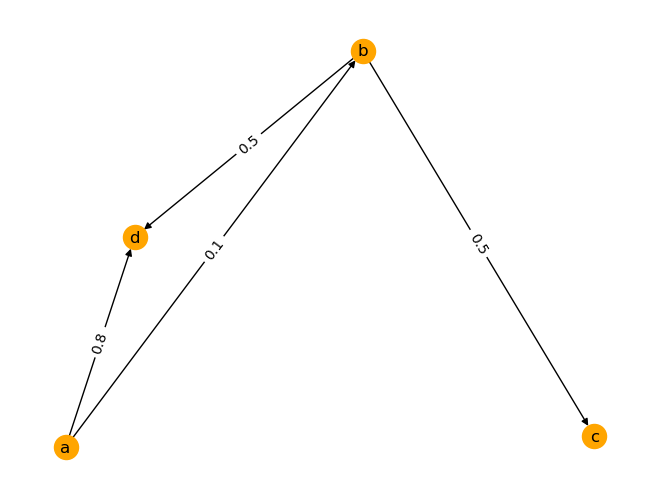

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_gph(g):
    pos = nx.spectral_layout(g)
    nx.draw(g, pos, with_labels=True, node_color='orange')
    labels = nx.get_edge_attributes(g, 'weight')
    nx.draw_networkx_edge_labels(g, pos, edge_labels=labels);

plot_gph(g)

In [6]:
import numpy as np
np.set_printoptions(suppress=True)

#               S0 S1   S2  S3
P = np.array([[0, 0.0, 0.5, 0.5],   # S0
            [1.0, 0.0, 0.0, 0.0],   # S1
            [0.0, 0.0, 0.0, 1.0],   # S2
            [0, 1.0, 0.0, 0.0]])    # S3

# Here S0, S1, S2, S3 are conceptual labels either
# for the Markov chain states or the digraph vertices

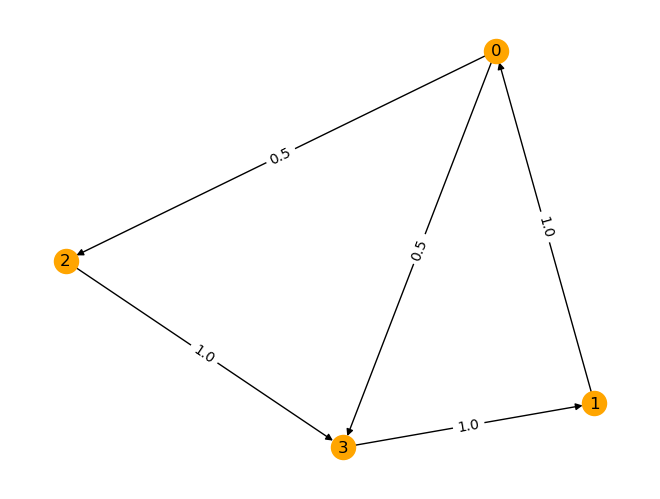

In [7]:
gP = nx.from_numpy_array(P, create_using=nx.DiGraph)

plot_gph(gP)

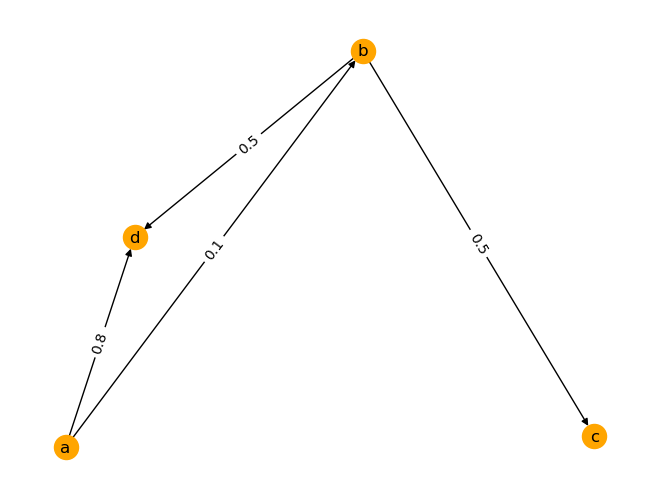

In [8]:
plot_gph(g)

In [9]:
g.nodes # note the ordering of vertices

NodeView(('a', 'b', 'd', 'c'))

In [10]:
import numpy as np
import scipy.sparse as sp

# Get the adjacency matrix of the graph
adj_matrix = nx.adjacency_matrix(g)

# Convert the adjacency matrix to a SciPy sparse matrix
Pg = sp.csr_matrix(adj_matrix)

# Convert the sparse matrix to a dense matrix if needed
Pg.todense()

matrix([[0. , 0.1, 0.8, 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]])

In [11]:
def PforG(p=0.4, N=10):
    q = 1 - p
    P = np.diag(q*np.ones(N), k=-1) + np.diag(p*np.ones(N), k=1)
    P[0, :] = 0
    P[0, 0] = 1
    P[N, :] = 0
    P[N, N] = 1
    return P

PforG(p=0.4)

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.6, 0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.6, 0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.6, 0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.6, 0. , 0.4, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0. , 0.4, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0.4, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0.4, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0.4],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

In [12]:
from numpy.linalg import eig, inv, det

P = PforG(p=0.4)
ew, ev = eig(P)
ew

array([-0.93184127, -0.79267153, -0.57590958, -0.30277358, -0.        ,
        0.93184127,  0.79267153,  0.30277358,  0.57590958,  1.        ,
        1.        ])

In [13]:
H = ev[:, abs(ew - 1) < 1e-15] # Eigenvectors of eigenvalue 1
M = np.array([H[0, :], H[-1, :]]) # Matrix of the two conditions
det(M)

0.2825542003687932

In [14]:
def Gchances(p=0.4, N=10):
    P = PforG(p, N)
    ew, ev = eig(P)
    H = ev[:, abs(ew - 1) < 1e-15]
    M = np.array([H[0, :], H[-1, :]])
    c = inv(M) @ np.array([0, 1])
    return H @ c

In [15]:
h = Gchances(p=0.4)
h

array([0.        , 0.00882378, 0.02205946, 0.04191297, 0.07169324,
       0.11636364, 0.18336924, 0.28387764, 0.43464024, 0.66078414,
       1.        ])

In [16]:
from random import uniform

def gamble(init=2, p=0.4, win=10, n=10000):
    
# """Let G gamble "n" times, starting with "init" chips."""

    wl = np.zeros(n) # mark win or lose here for each gamble i
    for i in range(n):
        chips = init
        while chips:
            if uniform(0, 1) > p: # losing game
                chips -= 1
            else: # winning game
                chips += 1
            if chips == win: # reached wanted winnings
                wl[i] = 1
                break
    return wl

In [17]:
n = 500000
wl = gamble(n=n)
print('Proportion of winning gambles:', np.count_nonzero(wl) / n)

Proportion of winning gambles: 0.021604


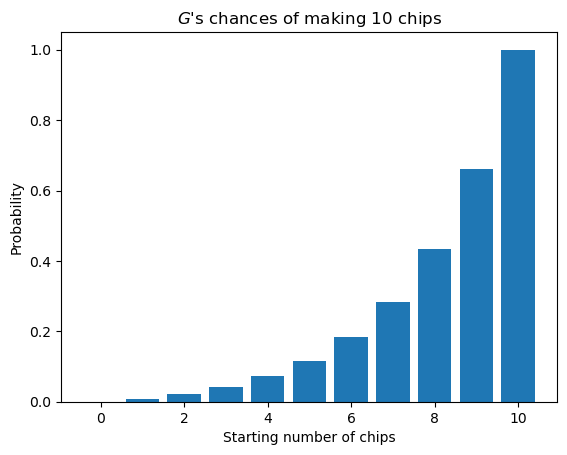

In [18]:
plt.bar(range(len(h)), h)
plt.title('$G$\'s chances of making 10 chips');
plt.xlabel('Starting number of chips'); plt.ylabel('Probability');

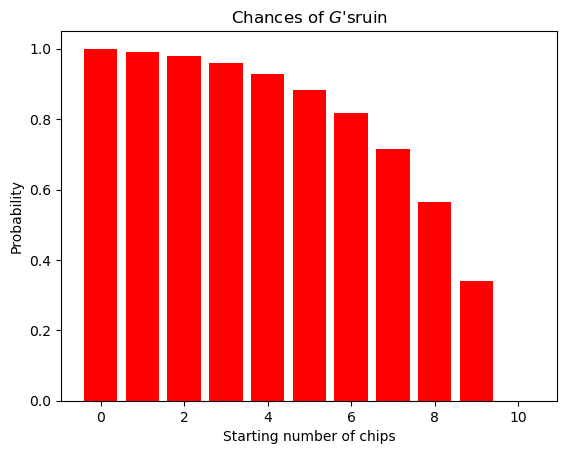

In [19]:
plt.bar(range(len(h)), 1-h, color='red')
plt.title('Chances of $G$\'sruin');
plt.xlabel('Starting number of chips'); plt.ylabel('Probability');

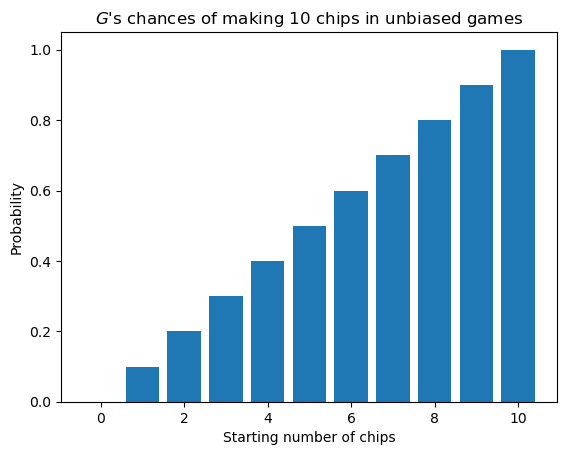

In [20]:
plt.bar(range(len(h)), Gchances(p=0.5, N=10))
plt.title('$G$\'s chances of making 10 chips in unbiased games');
plt.xlabel('Starting number of chips'); plt.ylabel('Probability');

In [21]:
A = [0, 10]
B = range(1, 10)
P = PforG()
PAA = P[np.ix_(A, A)]
PBA = P[np.ix_(B, A)]
PBB = P[np.ix_(B, B)]

In [22]:
PBA

array([[0.6, 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0.4]])

In [23]:
PBB

array([[0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.6, 0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.6, 0. , 0.4, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.6, 0. , 0.4, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.6, 0. , 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0. , 0.4, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0.4, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0.4],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. ]])

In [24]:
PAA

array([[1., 0.],
       [0., 1.]])

In [25]:
np.linalg.inv(np.eye(len(B)) - PBB) @ PBA

array([[0.99117622, 0.00882378],
       [0.97794054, 0.02205946],
       [0.95808703, 0.04191297],
       [0.92830676, 0.07169324],
       [0.88363636, 0.11636364],
       [0.81663076, 0.18336924],
       [0.71612236, 0.28387764],
       [0.56535976, 0.43464024],
       [0.33921586, 0.66078414]])

In [26]:
from scipy.sparse import diags, eye
from scipy.sparse.linalg import spsolve

In [27]:
def sparseGmats(p=0.4, N=10000):

# """ Return I - PBB and PBA as sparse matrices """

    q = 1 - p
    # Note that the first and last row of P are not accurate
    # in this construction, but we're going to trim them away:
    P = diags(q*np.ones(N), offsets=-1, shape=(N+1, N+1)) \
    + diags(p*np.ones(N), offsets=1, shape=(N+1, N+1))

    A = [0, N]
    B = range(1, N)
    I_PBB = (eye(N-1) - P[np.ix_(B, B)]).tocsc()
    PBA = P[np.ix_(B, A)].tocsc()

    return I_PBB, PBA

def ruinG(p=0.4, N=10000):
    # """ Given that the winning probability of each game is "p",
    # compute the probability of G's ruin for each starting state """

    I_PBB, PBA = sparseGmats(p, N)
    return spsolve(I_PBB, PBA[:, 0])

In [ ]:
ruinG(N=10)

In [ ]:
fig = plt.figure()
ax = plt.gca()

hs = ruinG(N=20)
ax.plot(hs[:21], 'r-', label='N=20')

hs = ruinG(N=30)
ax.plot(hs, 'r:', label='N=30')

hs = ruinG(N=40)
ax.plot(hs, 'r-.', label='N=40')

ax.set_ylabel('Probability of $G$\'s ruin')
ax.set_xlabel('Starting state index')
ax.legend();

In [ ]:
def least_ruin_prob(p=0.4, N0=20, dbl=11):

#""" Compute least ruin probability starting with N="N0" and
# recompute "dbl" times, doubling N each time. """

    for i in range(dbl):
        print('N = %5d, least ruin probability = %5.4f' %(N0*2**i, min(ruinG(p=p, N=N0*2**i)[:21])))

In [ ]:
least_ruin_prob(p=0.4, dbl=7)

In [ ]:
least_ruin_prob(p=0.5, dbl=11)